In [208]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import os
from glob import glob
from functools import reduce

from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score

In [3]:
def rcollapse(arr, sep=" "):
    try:
        sep=str(sep)
        results = reduce(lambda x,y: '{}{}{}'.format(x,sep, y), arr)
    except Exception as e:
        print(e)
        results=None
    finally:
        return(results)

In [4]:
path = 'H:/Documents/Training/Thinkful'
ny = 'crime.csv'
ma = 'crime_MA_2013.csv'

os.chdir(path)

In [5]:
train = pd.read_csv(ny)

In [6]:
md = pd.DataFrame()
md['org'] = train.columns
md['label'] = ['city', 'population', 'violent',
               'murder', 'rape1', 'rape2',
               'robbery', 'assault', 'property',
               'burglary', 'larceny', 'auto', 'arson']
# md

In [7]:
train.columns = md.label
train.columns.name=None
train.loc[:, 'violent':'arson'] = train.loc[:, 'population':'arson'].apply(lambda x: (x/train.population)*100000)
train.columns

Index(['city', 'population', 'violent', 'murder', 'rape1', 'rape2', 'robbery',
       'assault', 'property', 'burglary', 'larceny', 'auto', 'arson'],
      dtype='object')

In [8]:
tr_na = train.apply(lambda x: sum(x.isna()))
drp = tr_na.loc[tr_na>=len(train.index)*0.9].index.values

In [9]:
from functools import reduce
matches = list(filter(lambda x: x in drp, train.columns))
if len(matches)>0:
    train.drop(matches, axis=1, inplace=True)
train.columns

Index(['city', 'population', 'violent', 'murder', 'rape2', 'robbery',
       'assault', 'property', 'burglary', 'larceny', 'auto', 'arson'],
      dtype='object')

#### Correlation analysis
Property crime has too high a correlation to larceny--pearson coefficient = 0.99--for me to think that it's real. They're probably going to be nearly synonymous. Burglary is also highly correlated, with a Pearson coefficient of 0.78. In addition, there are 8 pairs of highly correlated variables that do not include property. Taking out 'robbery' and 'violent crime' might cut down significantly on colinearity between variables.

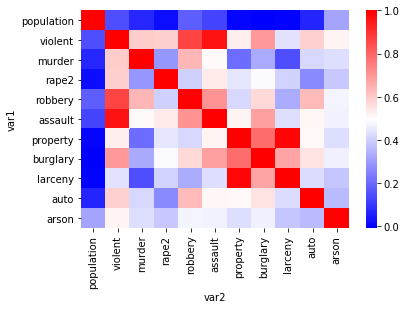

var2,population,violent,murder,rape2,robbery,assault,property,burglary,larceny,auto,arson
var1,,,,,,,,,,,
population,1.000000,0.150650,0.071966,0.020140,0.179951,0.129336,0.001928,-0.006458,0.000694,0.065369,0.317241
violent,0.150650,1.000000,0.598396,0.593339,0.862699,0.964336,0.531994,0.699370,0.440852,0.588651,0.518020
murder,0.071966,0.598396,1.000000,0.292214,0.639665,0.505044,0.209125,0.331165,0.150449,0.419435,0.433240
rape2,0.020140,0.593339,0.292214,1.000000,0.404048,0.539163,0.449445,0.485477,0.409399,0.264857,0.387016
robbery,0.179951,0.862699,0.639665,0.404048,1.000000,0.710264,0.419695,0.574677,0.334094,0.630768,0.476899
assault,0.129336,0.964336,0.505044,0.539163,0.710264,1.000000,0.517531,0.681732,0.431420,0.513545,0.470576
property,0.001928,0.531994,0.209125,0.449445,0.419695,0.517531,1.000000,0.787320,0.985987,0.508681,0.432694
burglary,-0.006458,0.699370,0.331165,0.485477,0.574677,0.681732,0.787320,1.000000,0.676478,0.553136,0.468143
larceny,0.000694,0.440852,0.150449,0.409399,0.334094,0.431420,0.985987,0.676478,1.000000,0.428265,0.384023


In [14]:
nc = train.drop('city', axis=1).corr()
nc.index.name='var1'
nc.columns.name='var2'

sns.heatmap(nc, cmap='bwr')
plt.show()

nc

##### High correlations, Pearson >= 0.6

In [15]:
long = nc.reset_index().melt(id_vars='var1', value_name='correlation', var_name='var2')
long.loc[(long.correlation >=0.6) &
         (long.correlation < 1) &
         (long.var1>long.var2)].sort_values(['var1', 'correlation'], ascending=False)

,var1,var2,correlation
56,violent,assault,0.964336
45,violent,robbery,0.862699
78,violent,burglary,0.699370
59,robbery,assault,0.710264
26,robbery,murder,0.639665
103,robbery,auto,0.630768
94,property,larceny,0.985987
83,property,burglary,0.787320
85,larceny,burglary,0.676478
62,burglary,assault,0.681732


#### Outlier Analysis

C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


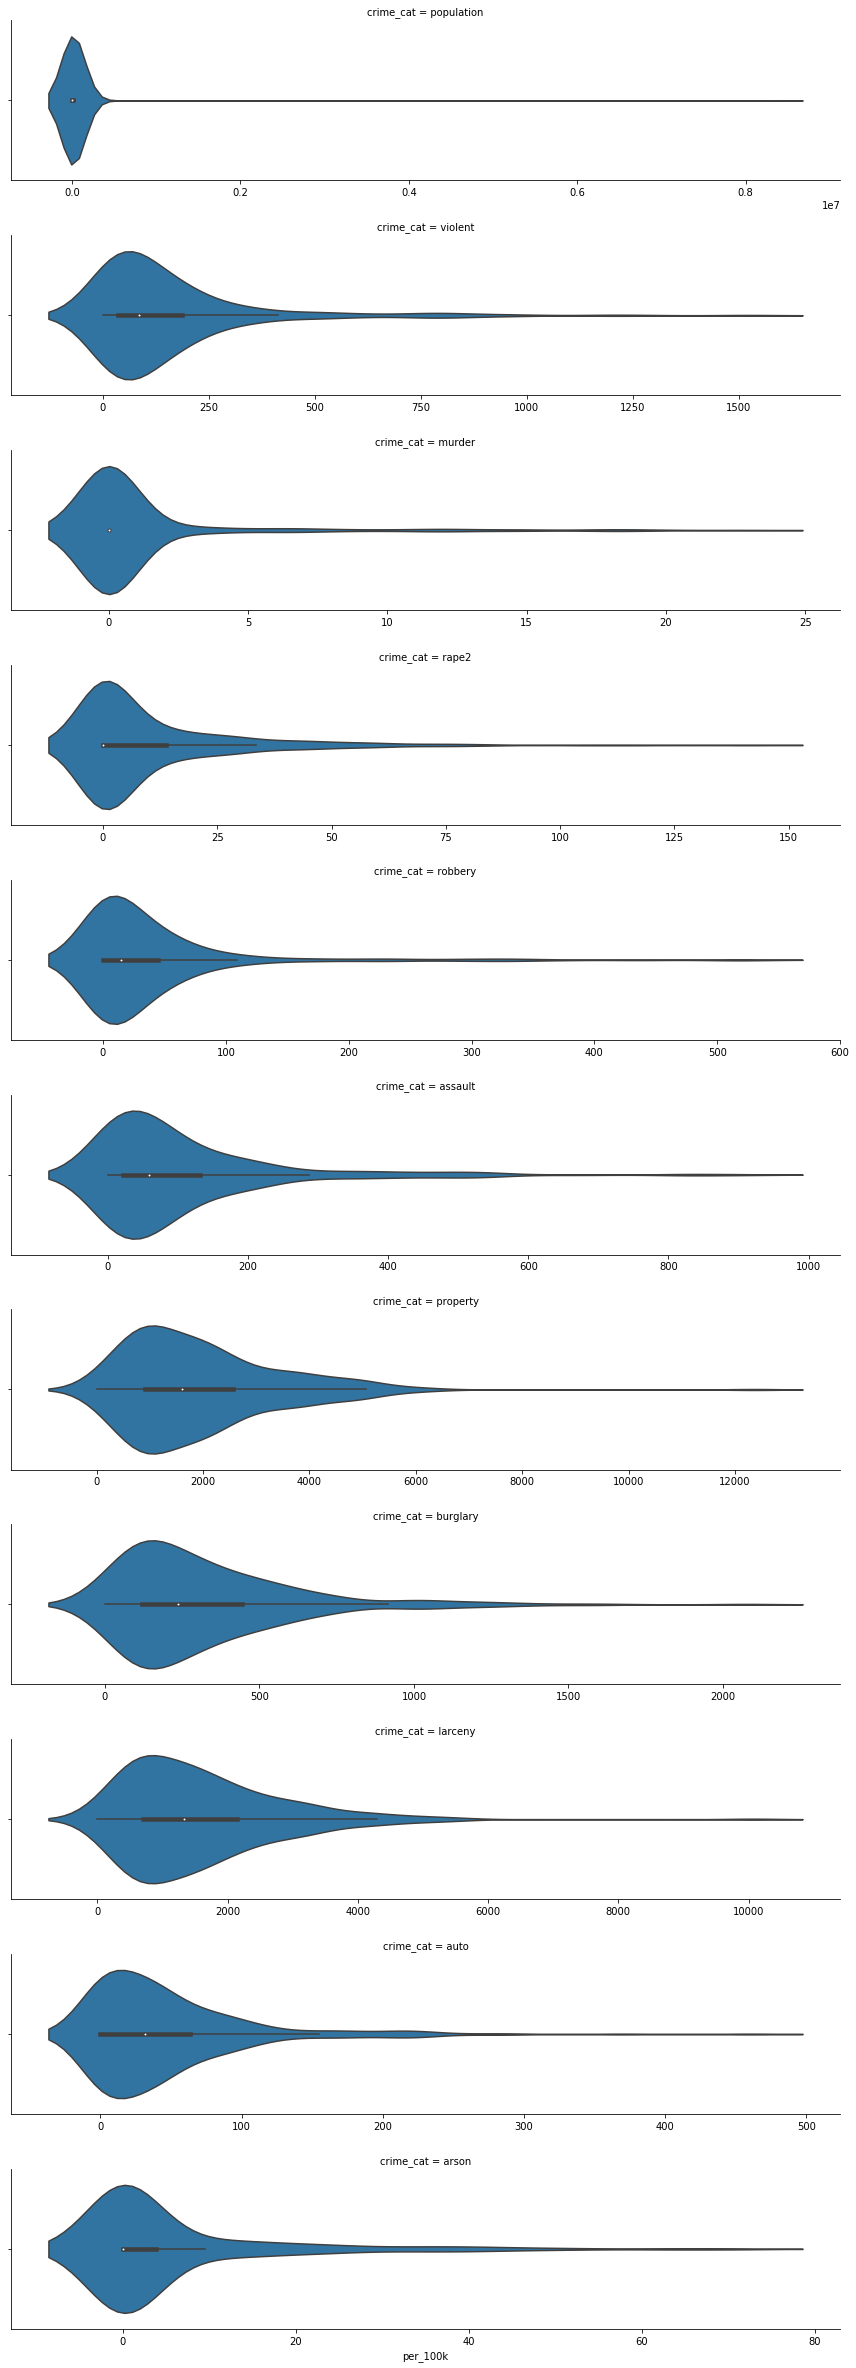

C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


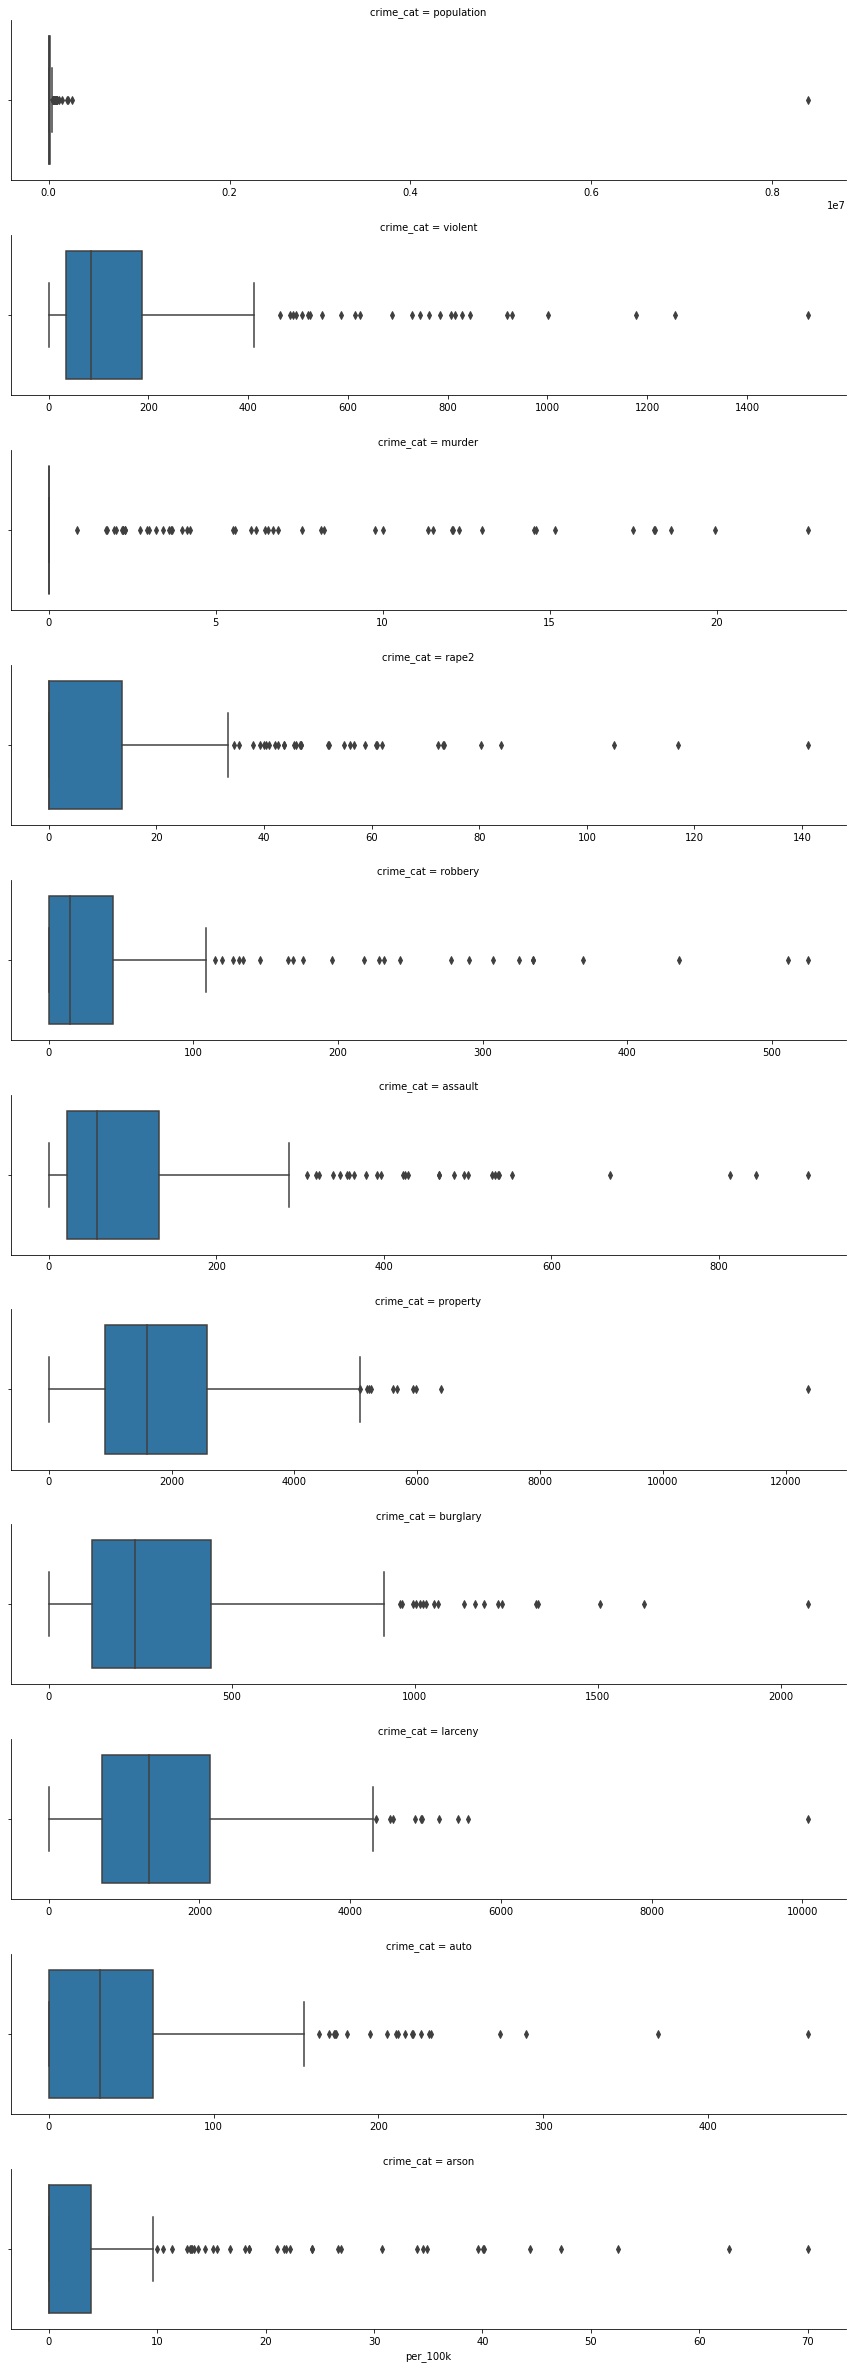

In [16]:
#  Violin plots
d_viol = train.loc[:, 'population':'arson'].melt(var_name='crime_cat', value_name='per_100k')

g = sns.FacetGrid(d_viol, row='crime_cat', sharex=False, aspect=4)
g.map(sns.violinplot, 'per_100k')
plt.show()

g = sns.FacetGrid(d_viol, row='crime_cat', sharex=False, aspect=4)
g.map(sns.boxplot, 'per_100k')

In [17]:
outliers = {'violent': [1400, 1100],
           'rape2': [100, 70],
           'robbery': [500, 400],
           'assault': [700, 600],
           'property': [10000],
           'burglary': [2000, 1450],
           'larceny': [10000],
           'auto': [260]}

outl = pd.DataFrame({'label': [x[0] for x in outliers.items()],
              'low_outlier': [min(x[1]) for x in outliers.items()],
              'high_outlier': [max(x[1]) for x in outliers.items()]})
md = pd.merge(md, outl, left_on='label', right_on='label', how='left')

In [19]:
for r in md.loc[~(md.low_outlier.isna())].index:
    lab = md.loc[r, 'label']
    train['{0}_outlier'.format(lab)] = train[lab]>=md.loc[r, 'low_outlier']

# Validating Original Model
Retained features:
- Rape, definition 2
- Violent crime
- Murder

Data scope:
- 2013 New York crime values'
- A single unusually high property data point was dropped

In [42]:
# Preparing 2013 New York dataset, including dropping an outlier
out = train.loc[train.property<6000]

# Regression using OLS, for better parameter visualization
mod = ols("property ~ rape2+murder+violent", data=out).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:               property   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     59.87
Date:                Sun, 05 May 2019   Prob (F-statistic):           3.91e-31
Time:                        13:45:40   Log-Likelihood:                -2906.3
No. Observations:                 346   AIC:                             5821.
Df Residuals:                     342   BIC:                             5836.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1327.7583     73.029     18.181      0.0

### Validating with Massachusetts 2013 Crime Data
The purpose of validating the model we built with New York data on Massachusetts crime data is to determine how generalizable our model is. Our goal may have been all along to build a national crime predictor. If we see a low R2 and mean square error then our model has essentially "overfit" to New York's data. A high R2 would mean that our initial model is generalizable beyond New York. What we in fact see is that we have a negative R2 score, which shouldn't be possible, and a very migh mean squared error.

In [57]:
# Preparing Massachusetts 2013 crime dataset for validation
dma = pd.read_csv(ma)
dma.loc[:, 'violent':'arson'] = dma.loc[:, 'violent':'arson'].apply(lambda x: x*100000/dma.population)
dma = dma.drop('rape2', axis=1)
dma.columns = dma.columns.str.replace(r'1', '2')
dma = dma[~dma.rape2.isna()]

X_test = dma[['violent', 'rape2', 'murder']]
y_test = dma['property']

In [66]:
X_train = feat[['violent', 'rape2', 'murder']]
y_train = feat['property']

val = lm.LinearRegression().fit(X_train, y_train)
y_pred = val.predict(X_train)

print('Training Model R2: {0}'.format(round(r2(y_train, y_pred), ndigits=3)))
print('Training Model MSE: {0}'.format(round(mse(y_train, y_pred), ndigits=3)))

Training Model R2: 0.325
Training Model MSE: 1434076.032


One thing to notice before we go through validation testing is that the training model isn't great. The predictors account for less than 50% of the variance in the target variable (property). But assuming we haven't overfit to New York, we would expect to see at least an R2 of around 0.3 when we look at the Massachusetts data. In fact, the test performance isn't anywhere near 0.3. Instead the R2 is negative and the MSE is huge.

In [69]:
# Predicting Massachusetts property crime rates using the NY-fitted model
ma_pred = val.predict(X_test)
print('MA R2: {0}'.format(round(r2(y_test, ma_pred), ndigits=3)))
print('MA MSE: {0}'.format(round(mse(y_test, ma_pred), ndigits=3)))

MA R2: -0.848
MA MSE: 1497548.812


### Exploring Variability between Massachusetts and New York
The mean residual value is nearly -1000 with a standard deviation of 763. While the distribution of residual values is somewhat left-tailed, the general symmetry of the residual value distribution suggests that one or both of the following may be at play:
- Property crime values are generally much lower in Massachusetts compared to New York and the intercept is throwing off everything else; or
- The relationships between predictor variables and property are smaller in Massachusetts than in New York.

Mean MA Residual Value: -958.07
Std Deviation of MA Residuals: 762.767


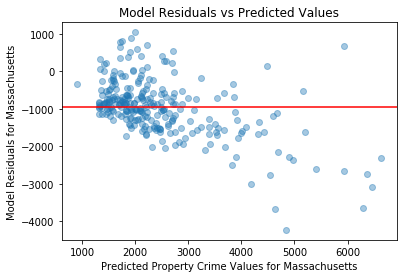

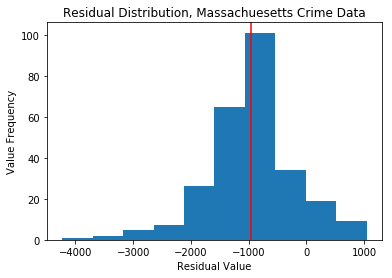

In [80]:
rtest = y_test - ma_pred
mn_res = rtest.mean()
std_res = rtest.std()
print('Mean MA Residual Value: {0}'.format(round(mn_res, ndigits=3)))
print('Std Deviation of MA Residuals: {0}'.format(round(std_res, ndigits=3)))

plt.scatter(ma_pred, rtest, alpha=0.4)
plt.axhline(y=mn_res, color="red")
plt.title("Model Residuals vs Predicted Values")
plt.xlabel("Predicted Property Crime Values for Massachusetts")
plt.ylabel("Model Residuals for Massachusetts")
plt.show()

plt.hist(rtest)
plt.axvline(x=mn_res, color="red")
plt.title("Residual Distribution, Massachuesetts Crime Data")
plt.xlabel("Residual Value")
plt.ylabel("Value Frequency")
plt.show()

In [36]:
flds = ['violent', 'rape2', 'murder', 'property', 'auto', 'burglary']
ama = pd.DataFrame()
ama = dma[flds]
ama.index = dma.city
ama.index.name=None
ama.loc[:, 'state'] = 'MA'

fny = pd.DataFrame()
fny = train[flds]
fny.index=train.city
fny.index.name=None
fny.loc[:, 'state'] = 'NY'

many = pd.concat([ama, fny], sort=False).melt(id_vars=['state', 'property'])

C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


When we explore bivariate plots from Massachusetts side by side with New York, it appears that both might be at play.

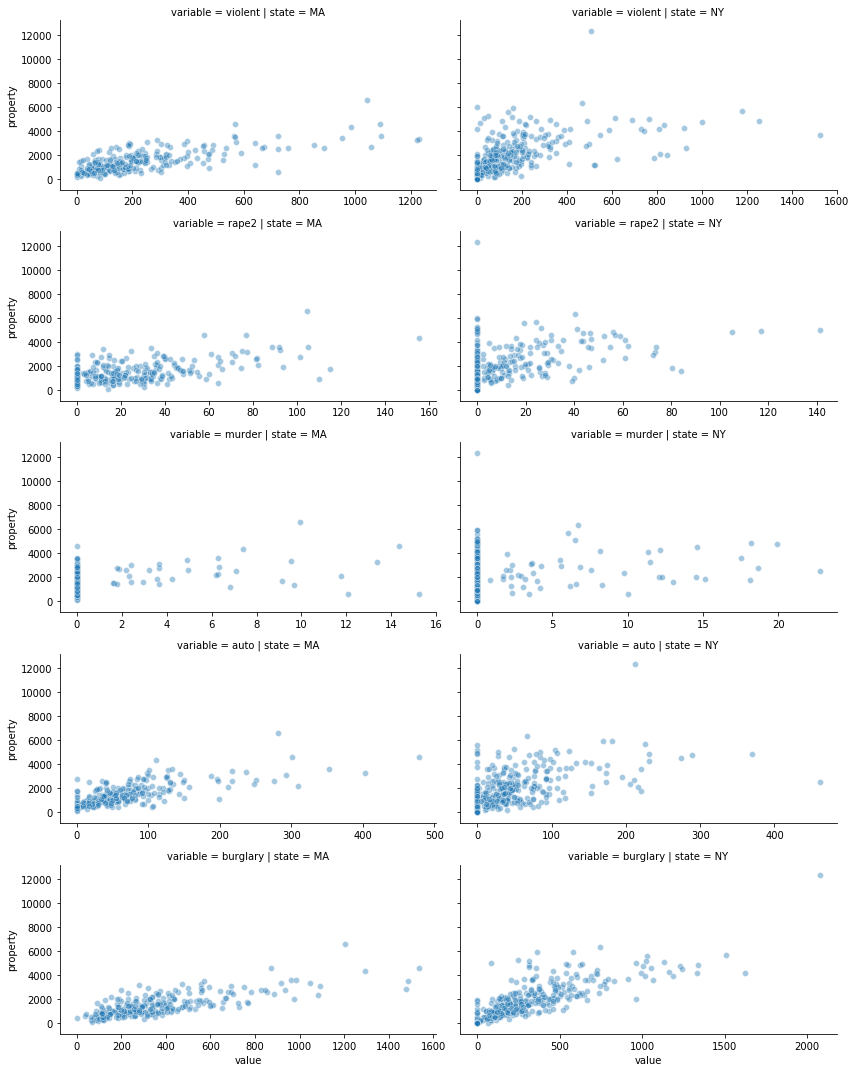

In [181]:
# f, ax = plt.subplots(**{'figsize':(20, 10)})
g = sns.FacetGrid(many, row='variable', col='state', aspect=2, height=3, sharex=False)
g.map(sns.scatterplot, 'value', 'property', alpha=0.4)
plt.show()

# Model Variation 1: Include better predictors (burglary)
One approach to creating a more valid model is to focus on variables that exhibit a better relationship with property crime than the ones already used in our model. To this end, I added burglary to my model. The R2 for a univariate predictor for property using only burglary is 0.620. Compared to the predictors in the original model--violent crime, rape, and murder--the next highest R2 value is violent crime at 0.283.

In [175]:
def typeI_skl(*cols, target=None, df=None):
    xtrains = (pd.DataFrame(df[x]) for x in cols)
    preds = list(map(lambda x: lm.LinearRegression().fit(x, df[target]).predict(x), xtrains))
    r2s = list(map(lambda x: r2(df[target], x), preds))
    result = dict(zip(cols, r2s))
    return(result)

predictors = ['burglary', 'murder', 'violent', 'rape2']
typI = pd.Series(typeI_skl('burglary', 'murder', 'violent', 'rape2', target='property', df=train)).sort_values(ascending=False)

print('Type I SS analysis for the following indicators:')
print(typI)

# Note: add error handling for variables that don't exist

Type I SS analysis for the following indicators:
burglary    0.619872
violent     0.283018
rape2       0.202000
murder      0.043733
dtype: float64


However, the R2 values indicate that the new model does not perform significantly better than our old model.

In [180]:
X_train = train[predictors]
y_train = train.property

X_test = dma[predictors]
y_test = dma.property

b = lm.LinearRegression().fit(X_train, y_train)
t_pred = b.predict(X_train)

pred = b.predict(X_test)
val = r2(y_test, pred)

print('New model R2: {0}'.format(round(b.score(X_train, y_train), ndigits=3)))
print('New model MSE: {0}\n'.format(round(mse(y_train, t_pred), ndigits=3)))
print('New model R2, Massachusetts data: {0}'.format(round(val, ndigits=3)))
print('New model MSE, Massachusetts data: {0}'.format(round(mse(y_test, pred), ndigits=3)))

New model R2: 0.631
New model MSE: 783411.344

New model R2, Massachusetts data: -0.256
New model MSE, Massachusetts data: 1017861.197


### Residual visualizations
Residual values are more or less normally distributed around a mean of -709.482. That's better than our original model, but suggests that the intercept is too high, the relationship is too positive, or both. The scatterplot indicates that most likely it's both. Residual values for low predicted values are still negative, but the residuals appear to trend more negative as predicted values increase. This suggests a positive slope that is inappropriately large. This aligns with our observations of the bivariate plots. In addition, the scatterplot shows more datapoints clustered at lower predicted values and fewer residuals at higher predicted values. This is consistent with the slightly left-tailed residual distribution we see in the histogram.

Mean MA Residual Value: -709.482
Std Deviation of MA Residuals: 718.621


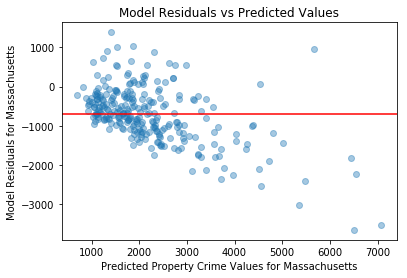

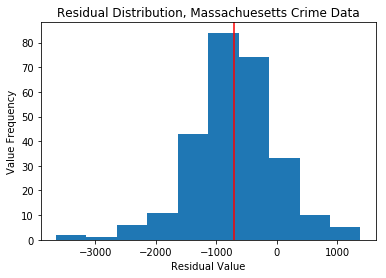

In [182]:
rtest = y_test - pred
mn_res = rtest.mean()
std_res = rtest.std()
print('Mean MA Residual Value: {0}'.format(round(mn_res, ndigits=3)))
print('Std Deviation of MA Residuals: {0}'.format(round(std_res, ndigits=3)))

plt.scatter(pred, rtest, alpha=0.4)
plt.axhline(y=mn_res, color="red")
plt.title("Model Residuals vs Predicted Values")
plt.xlabel("Predicted Property Crime Values for Massachusetts")
plt.ylabel("Model Residuals for Massachusetts")
plt.show()

plt.hist(rtest)
plt.axvline(x=mn_res, color="red")
plt.title("Residual Distribution, Massachuesetts Crime Data")
plt.xlabel("Residual Value")
plt.ylabel("Value Frequency")
plt.show()

# Model Variation 2: Using MA and NY data for the training set
Another way to think about changing the model is to use MA and NY in the training set, but to hold out a portion of both datasets for testing. I will include burglary, as well as my original three predictor variables. I'm also interested to see whether my testing accuracy changes depending on whether I hold out 20% of both the MA and NY records compared to setting aside random records.

## Random test sets
When we split our data randomly, the resulting R2 values have a very wide range indicating that the accuracy of the model is highly dependent on the distribution of state records in the training and testing datasets. For 10 folds, the average R2 value is 0.458 with a standard deviation of 0.168. The highest R2 value was 0.7 while the lowest was 0.138.

In [206]:
# Creating combined dataset
train['state'] = 'NY'
dma['state'] = 'MA'

comb = pd.concat([train[predictors+['property', 'state']],
                  dma[predictors+['property', 'state']]]).reset_index().drop('index', axis=1)

X = comb.drop(['state', 'property'], axis=1)
y = comb.property

In [235]:
# 5-fold cross validation
model = lm.LinearRegression()
cv = cross_val_score(model, X, y, cv=10, scoring='r2')
print('Mean R2, cv=10: {0}'.format(round(np.mean(cv), ndigits=3)))
print('Standard deviation, cv=10: {0}'.format(round(np.std(cv), ndigits=3)))
print('\nR2 values from 10 folds:')
print(sorted([round(x, ndigits=3) for x in cv], reverse=True))

Mean R2, cv=10: 0.458
Standard deviation, cv=10: 0.168

R2 values from 10 folds:
[0.701, 0.69, 0.551, 0.514, 0.498, 0.434, 0.422, 0.387, 0.243, 0.138]


## Equal state frequencies for New York and MA
When we train on an equal number of New York and MA records we achieve overall higher and much more consistent R2 values. Even testing with all holdouts, we achieve an average R2 of 0.554ith a standard deviation of 0.048. Also, we see a strong negative relationship between the training R2 and the testing R2, which we would expect.

In [315]:
tests = []

for i in range(0, 10):
    test = {}
    homa = dma.sample(frac=0.2)

    ma_full = dma.loc[~dma.index.isin(homa.index)]
    ny_full = train.sample(len(ma_full.index))
    hony = train[~train.index.isin(ny_full.index)]

    train_full = pd.concat([ma_full, ny_full[ma_full.columns]])

    X_train = train_full[predictors]
    y_train = train_full.property

    test_full = pd.concat([hony[homa.columns], homa])
    X_test = test_full[predictors]
    y_test = test_full.property

    mod = lm.LinearRegression().fit(X_train, y_train)
    pred_train = mod.predict(X_train)
    pred_test = mod.predict(X_test)
    
    test['model_r2'] = r2(y_train, pred_train)
    test['model_mse'] = mse(y_train, pred_train)
    test['test_r2'] = r2(y_test, pred_test)
    test['test_mse'] = mse(y_test, pred_test)
    
    tests.append(test)

Average test R2: 0.554
Std test R2: 0.048
Test R2 range: 0.613, 0.46


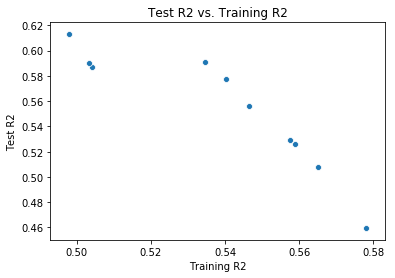

In [316]:
dplot = pd.DataFrame()
dplot['mod_r2'] = [x['model_r2'] for x in tests]
dplot['test_r2'] = [x['test_r2'] for x in tests]

print('Average test R2: {0}'.format(round(dplot.test_r2.mean(), ndigits=3)))
print('Std test R2: {0}'.format(round(dplot.test_r2.std(), ndigits=3)))
print('Test R2 range: {0}, {1}'.format(round(dplot.test_r2.max(), ndigits=3), round(dplot.test_r2.min(), ndigits=3)))

sns.scatterplot('mod_r2', 'test_r2', data=dplot)
plt.title('Test R2 vs. Training R2')
plt.xlabel('Training R2')
plt.ylabel('Test R2')
plt.show()